In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
import pandas as pd

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from datetime import datetime
months =[datetime(2019, imon, 1) for imon in np.arange(1,12+1)]
month_str = [date_obj.strftime('%b') for date_obj in months]
m_str = [w[0] for w in month_str];

# from mpl_toolkits.basemap import basemap

In [2]:
#Typical correlation function

def cor(x,y):
    xa = x - np.nanmean(x)
    ya = y - np.nanmean(y)
    return np.nansum(xa*ya)/np.sqrt(np.nansum(xa**2)*np.nansum(ya**2))

I am doing a project about hurricanes, so my biggest source of data is National Hurricane Center's HURDAT2. Short for 'HURricane DATa 2'. This gives several pieces of information about every named tropical or extratropical atlantic storm since 1815-ish.  Since most other relevant data doesn't go back so far on a high enough spatial/temporal resolution, I am only using values since 1980. 

This data includes latitude, longitude, zonal wind, meridional wind, maximum sustained wind speed, distance traveled since last measurement, date, storm classification, and more, all on a 6-hour temporal scale.

Here's what the data looks like:



AL041989,            CHANTAL,     16,

19890730, 1200,  , TD, 22.5N,  90.0W,  20, 1011, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999,

19890730, 1800,  , TD, 23.5N,  90.2W,  25, 1010, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999,

19890731, 0000,  , TD, 24.4N,  90.5W,  30, 1009, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999,

19890731, 0600,  , TS, 25.4N,  91.0W,  35, 1004, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999,

19890731, 1200,  , TS, 26.2N,  91.7W,  50,  995, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999,

19890731, 1800,  , TS, 27.1N,  92.2W,  55,  993, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999,

19890801, 0000,  , HU, 27.9N,  92.8W,  65,  991, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999,

19890801, 0600,  , HU, 28.7N,  93.5W,  70,  987, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999, -999,



.......etc. for thousands of lines

This is a bit unruly, so I pre-processed data in a CSV to group storms by name, add a unique 'key' to identify each storm, and add a year column. Then, I load it into a pandas dataframe and turn it into an xarray

In [3]:
#Load Data

hdpd = pd.read_csv('points_with_gridIds_reLabel_year.csv')
hd = pd.DataFrame.to_xarray(hdpd)

In [10]:
#Here's what it looks like

hd.head().values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:     (index: 5)
Coordinates:
  * index       (index) int64 0 1 2 3 4
Data variables:
    Unnamed: 0  (index) int64 0 1 2 3 4
    month       (index) int64 6 6 6 6 6
    day         (index) int64 2 2 3 3 3
    Date        (index) int64 1200 1800 0 600 1200
    Class       (index) object ' TD' ' TD' ' TD' ' TS' ' TS'
    Lat         (index) float64 21.7 22.2 22.6 22.8 23.2
    Lon         (index) float64 87.1 86.5 85.8 85.0 84.2
    Max wind    (index) int64 20 25 30 40 50
    Min pres    (index) int64 1005 1004 1003 1001 995
    SST         (index) float64 27.51 28.15 27.47 27.0 26.99
    UWND        (index) float64 -4.15 -4.15 -1.16 -1.16 -1.16
    VWND        (index) float64 1.58 1.58 7.43 7.43 7.43
    rhum        (index) float64 78.38 78.38 82.73 82.73 82.73
    airtemp     (index) float64 300.1 300.1 300.4 300.4 300.4
    key         (index) object '            ALBERTO1982' ... '            ALB...
    year        (index) f

The 'question' that I'm trying to address is very broad. 

Is there a strong relationship between nino3.4 values and Atlantic hurricane activity?
To find this, I will be testing the correlation between nino3.4 (at many different lags/prediciton times) and several hurricane statistics. In my mind now, I have hurricane severity, number of hurricanes, how many hurricanes make landfall, etc.
Hopefully, these correlation values appear non trivial and I can do some analysis of the data I produce. If not, I will go back to the drawing board with methods and keep trying. I am not sure that I will accomplish anything magical, but I will have fun with it.

Below, you will see some of the work I have already done. I tried to document it, but there is probably some missing information.

Examples physical results I've produced:

1. A plot of the longest hurricane path in the dataset

2. Overlaid plots of every hurricane path, with the map in the background

3. Correlations between Nino3.4 and hurricane stats at different lag times

4. A couple regressions of Nino3.4 with hurricane stats.

In [11]:
#Sort by how many data points just for fun

size = hd.groupby('key').count()
sorted = size.sortby('day', ascending = False)

In [12]:
#Switch Longitutde to Degrees East

hd['Lon'] = -1*hd['Lon']
hdpd['Lon'] = -1*hdpd['Lon']

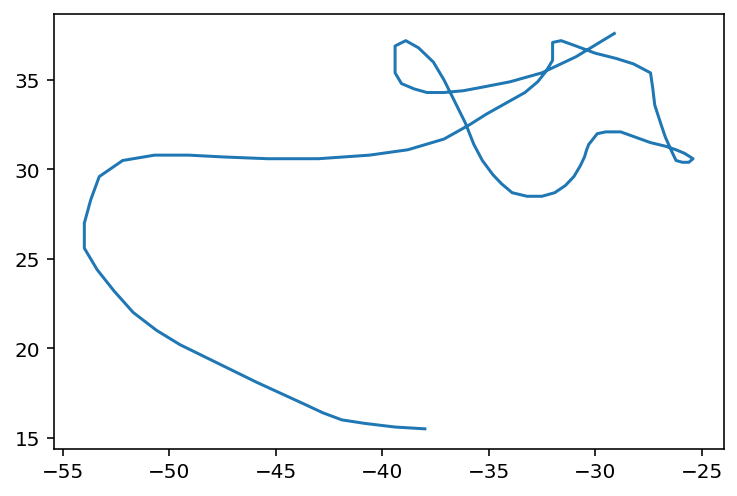

In [13]:
#Let's see what longest path looks like

j = hd.get(['key', 'Lat', 'Lon'])
nad = j.where(j['key'] == sorted.key[0], drop = True)
plt.plot(nad['Lon'].values, nad['Lat'].values)

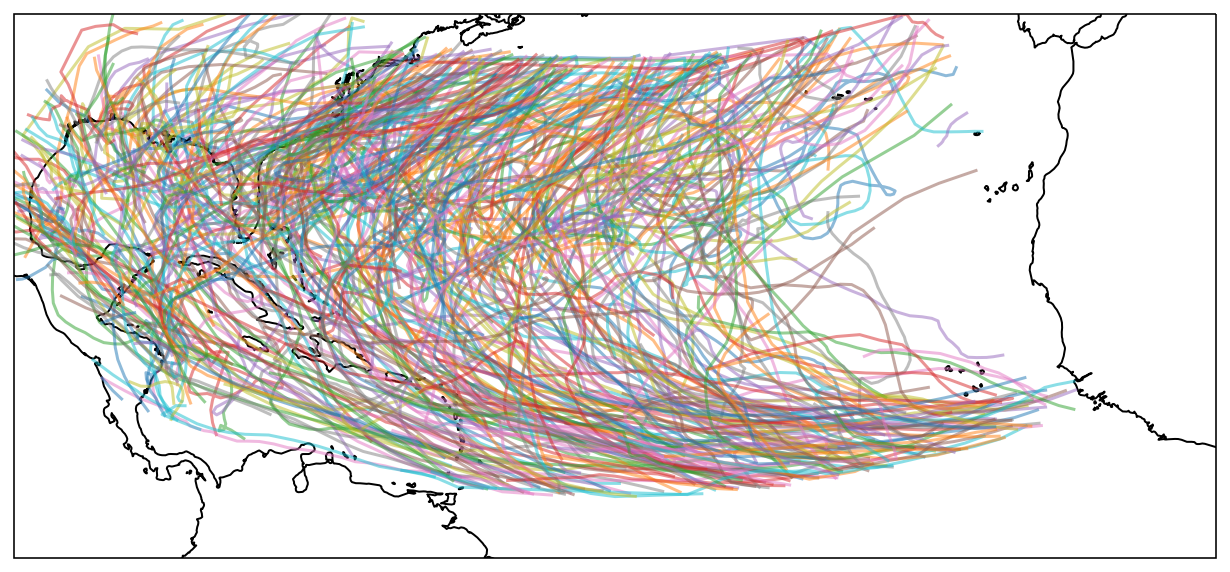

In [14]:
proj_map = ccrs.LambertConformal(central_longitude=-50, central_latitude=27.5)
proj_dta = ccrs.PlateCarree()  # the data's projection

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(projection=proj_map)

extent = [-90, -10, 5, 40]

#Plot 'em all

for i in range(0,481):
    th = j.where(j['key'] == sorted.key[i], drop = True)
    plt.plot(th['Lon'].values, th['Lat'].values, transform=proj_dta, alpha = 0.5)

ax.coastlines();
ax.set_extent(extent)

In [15]:
# myindices = []

# year = str(2005)
# for i in range(len(hd['key'])):
#     if hd['key'].values[i][-4:] == year:
#         myindices.append(i)
            
# lat05 = hd.Lat[myindices]
# lon05 = hd.Lon[myindices]
# key05 = hd.key[myindices]

# myAr = np.array((key05, lat05, lon05))
# myXr = xr.DataArray(myAr)

In [16]:
# proj_map = ccrs.LambertConformal(central_longitude=-50, central_latitude=27.5)
# proj_dta = ccrs.PlateCarree()  # the data's projection

# fig = plt.figure(figsize = (12,5))
# ax = plt.subplot(projection = proj_map)

# extent = [-100, -10, 5, 45]

# D05 = hdpd['year'] == 2005 
# X = np.arange(-100,-10, 5)
# Y = np.arange(10, 45, 5)
# H, xedges, yedges = np.histogram2d(hdpd['Lon'][D05], hdpd['Lat'][D05], bins = [X, Y])
# H[H == 0 ] = np.nan

# g = ax.pcolormesh(X, Y, H.T, transform = proj_dta)

# # plt.plot(-hdpd['Lon'][D05], hdpd['Lat'][D05], transform=proj_dta, linewidth = 6, alpha = 0.5)

# ax.coastlines();
# ax.set_extent(extent)
# plt.colorbar(g)

In [17]:
# xr05 = pd.DataFrame.to_xarray(hdpd[D05])

In [18]:
# proj_map = ccrs.LambertConformal(central_longitude=-50, central_latitude=27.5)
# proj_dta = ccrs.PlateCarree()  # the data's projection

# fig = plt.figure(figsize = (24,10))
# ax = plt.subplot(projection = proj_map)

# extent = [-100, -10, 5, 45]

# for i in xr05.groupby('key').count().key:
#     pt = xr05.where(xr05['key'] == i, drop = True)
#     plt.plot(pt['Lon'].values, pt['Lat'].values, transform=proj_dta, linewidth = 6, alpha = 0.5, label = i.values)
    
# ax.coastlines();
# ax.set_extent(extent)
# ax.legend()

In [21]:
#Get a list of all keys to easily access each storm

allkeys = hd.groupby('key').count().key.values

In [20]:
#I want a dataset with just year, key, landfall (T/F)

In [22]:
#create a pandas dataframe and fill it with data for each storm:
#Year, did it become hurricane? Y/N, did it make landfall? Y/N, max wind speed, minimum atm. pressure, and unique key

biglist = pd.DataFrame(columns = ['Year', 'Hurr', 'Landfall', 'MaxSpeed', 'MinPres', 'key'], index = np.arange(0,len(allkeys)))

for key in range(len(allkeys)):
    
    #initialize values
    maxspeed = 0
    minpres = 99999
    year = allkeys[key][-4:]
    minTemp = 1000
    landfall = False
    hurr = False
    thisHurr = hd.where(hd['key'] == allkeys[key], drop = True)
    
    #Get whether landfall
    for i in thisHurr['SST']:
        if i < minTemp:
            minTemp = i
    if minTemp == 0:
        landfall = True
        
    #Get max wind
    for j in thisHurr['Max wind']:
        if j.values > maxspeed:
            maxspeed = j.values
            
    #Get min pres
    for k in thisHurr['Min pres']:
        if k.values < minpres:
            minpres = k.values
            
    #WasHurr?
    for l in thisHurr['Class']:
        if l.values == ' HU':
            hurr = True
            
    #Add to list
    biglist.loc[key] = [year, hurr, landfall, maxspeed, minpres, allkeys[key]]

In [24]:

#empty list 
yearcount = []
# xar = xr.DataArray(biglist)

#Sort list and re-index
inOrder = biglist.sort_values('Year')
inOrder.index = np.arange(0,len(allkeys))

speedbins = (inOrder.MaxSpeed.min()-1, inOrder.MaxSpeed.mean(), inOrder.MaxSpeed.max()+1)
# speedbins

#define some quantiles for max wind speed
speedQuant = np.quantile(inOrder.MaxSpeed, [0.2, 0.8])

#individual yearly values for reg.
years = np.arange(1982, 2020)
for i in years:
    thisYearFalls = 0
    thisYearTot = 0
    thisYearFast = 0
    thisYearPres = 1100
    thisYearHurr = 0
    sLow = 0
    sMed = 0
    sHigh = 0
    sOut = 0
    for j in range(len(inOrder)):
        
        #Check this year
        if inOrder.Year[j] == str(i):
            thisYearTot += 1
            
            s = inOrder.MaxSpeed[j]
            
            #add up landfall count
            if inOrder.Landfall[j] != False:
                thisYearFalls += 1
                
            #Get max wind speed
            if s > thisYearFast:
                thisYearFast = inOrder.MaxSpeed[j]
                
            #Speed bins, return one's proportion
            if s < speedQuant[0]:
                sLow += 1
            elif s > speedQuant[1]:
                sHigh += 1
            else:
                sMed += 1
                
            if s > speedQuant[1] or s < speedQuant[0]:
                sOut += 1
                
            #Get min press
            if inOrder.MinPres[j] < thisYearPres and inOrder.MinPres[j] > 0:
                thisYearPres = inOrder.MinPres[j]
                
            #Add up hurricane count
            if inOrder.Hurr[j] != False:
                thisYearHurr += 1
                
    #Put data in list
    yearcount.append([i, sHigh/(sLow+sMed+sHigh), thisYearHurr / thisYearTot, thisYearFast, thisYearPres, thisYearFalls, thisYearFalls / thisYearTot, thisYearTot])
    
#Create df with list data
resF = pd.DataFrame(yearcount, columns = ['Year', 'PropSev', 'PropHurr', 'MaxSpeed', 'MinPress', 'NumLand', 'Prop', 'Count'])

In [341]:
# #Open Nino. Dont want to use aug/sep but will for now

# n34_Sep_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.n34_Sep/dods'
# n34_Sep_ds = xr.open_dataset(n34_Sep_url)
# n34_Sep = n34_Sep_ds.n34_Sep - n34_Sep_ds.n34_Sep.mean('T')

# # n34_Aug['T'].dt.year
# preds = n34_Sep[2:-2].values

In [25]:
#This may be unnecessary

n34 = xr.open_dataset('n34T.nc')
n34 = n34-n34.mean('T')
Jan = 1
Feb = 2
Mar = 3
Apr = 4
May = 5
Jun = 6
Jul = 7
Aug = 8
Sep = 9
Oct = 10
Nov = 11
Dec = 12
n34_Jan = n34.n34.where(n34['T'].dt.month == Jan, drop = True)
n34_Feb = n34.n34.where(n34['T'].dt.month == Feb, drop = True)
n34_Mar = n34.n34.where(n34['T'].dt.month == Mar, drop = True)
n34_Apr = n34.n34.where(n34['T'].dt.month == Apr, drop = True)
n34_May = n34.n34.where(n34['T'].dt.month == May, drop = True)
n34_Jun = n34.n34.where(n34['T'].dt.month == Jun, drop = True)
n34_Jul = n34.n34.where(n34['T'].dt.month == Jul, drop = True)
n34_Aug = n34.n34.where(n34['T'].dt.month == Aug, drop = True)
n34_Sep = n34.n34.where(n34['T'].dt.month == Sep, drop = True)
n34_Oct = n34.n34.where(n34['T'].dt.month == Oct, drop = True)
n34_Nov = n34.n34.where(n34['T'].dt.month == Nov, drop = True)
n34_Dec = n34.n34.where(n34['T'].dt.month == Dec, drop = True)

In [26]:
#Try starting year from November

cc2 = np.empty((7,12))
for imonth in range(0,12):
    if imonth != 10 and imonth != 11:
        cc2[0, (imonth+2)%12] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:-1].values, resF['MaxSpeed'])
        cc2[1, (imonth+2)%12] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:-1].values, resF['MinPress'])
        cc2[2, (imonth+2)%12] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:-1].values, resF['Prop'])
        cc2[3, (imonth+2)%12] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:-1].values, resF['Count'])
        cc2[4, (imonth+2)%12] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:-1].values, resF['PropHurr'])
        cc2[5, (imonth+2)%12] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:-1].values, resF['NumLand'])
        cc2[6, (imonth+2)%12] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:-1].values, resF['PropSev'])
    else:
        cc2[0, (imonth+2)%12] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[1:-1].values, resF['MaxSpeed'])
        cc2[1, (imonth+2)%12] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[1:-1].values, resF['MinPress'])
        cc2[2, (imonth+2)%12] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[1:-1].values, resF['Prop'])
        cc2[3, (imonth+2)%12] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[1:-1].values, resF['Count'])
        cc2[4, (imonth+2)%12] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[1:-1].values, resF['PropHurr'])
        cc2[5, (imonth+2)%12] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[1:-1].values, resF['NumLand'])
        cc2[6, (imonth+2)%12] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[1:-1].values, resF['PropSev'])

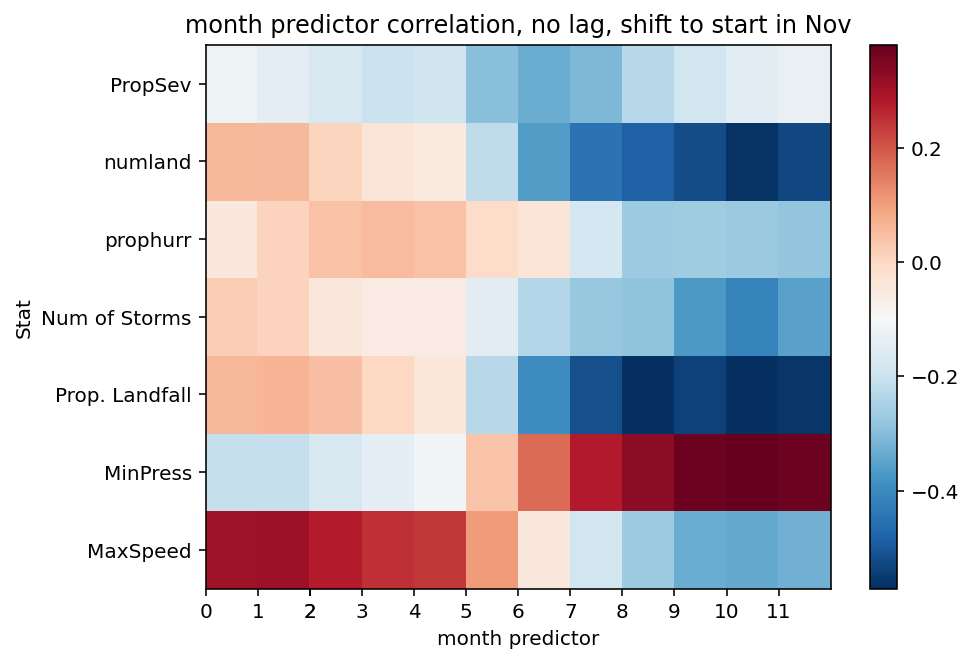

In [27]:
fig, ax = plt.subplots(figsize = (7, 5))  

g = ax.pcolormesh(np.arange(0, 12 + 1), np.arange(0, 8) + 0.5, cc2, vmax=cc2.max(), vmin=cc2.min(), cmap='RdBu_r')

ax.set_yticks(np.arange(1,8))
ax.set_yticklabels(['MaxSpeed','MinPress','Prop. Landfall', 'Num of Storms','prophurr','numland', 'PropSev'])
ax.set_xticks((np.arange(0,13)+2)%12)
plt.colorbar(g)
ax.set_ylabel('Stat')
ax.set_xlabel('month predictor')
ax.set_title('month predictor correlation, no lag, shift to start in Nov');

In [28]:
#Test some correlations

cc = np.empty((7,12))
for imonth in range(0,12):
    if imonth != 10 and imonth != 11:
        cc[0, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:-1].values, resF['MaxSpeed'])
        cc[1, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:-1].values, resF['MinPress'])
        cc[2, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:-1].values, resF['Prop'])
        cc[3, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:-1].values, resF['Count'])
        cc[4, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:-1].values, resF['PropHurr'])
        cc[5, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:-1].values, resF['NumLand'])
        cc[6, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:-1].values, resF['PropSev'])
    else:
        cc[0, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:].values, resF['MaxSpeed'])
        cc[1, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:].values, resF['MinPress'])
        cc[2, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:].values, resF['Prop'])
        cc[3, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:].values, resF['Count'])
        cc[4, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:].values, resF['PropHurr'])
        cc[5, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:].values, resF['NumLand'])
        cc[6, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:].values, resF['PropSev'])

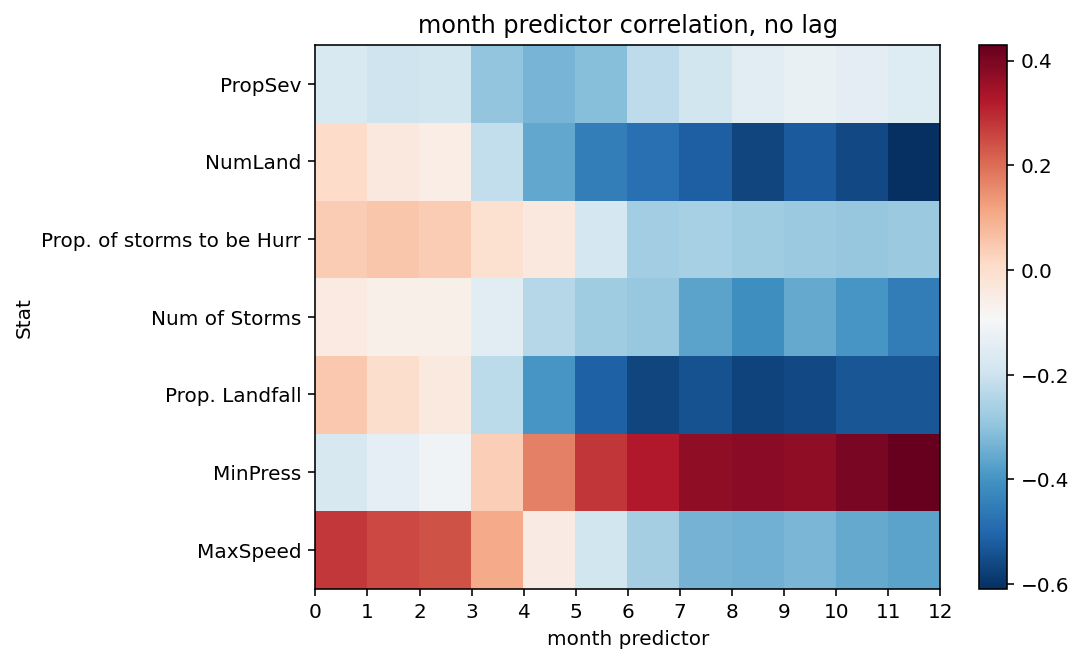

In [29]:
fig, ax = plt.subplots(figsize = (7, 5))  

g = ax.pcolormesh(np.arange(0, 12 + 1), np.arange(0, 8) + 0.5, cc, vmax=cc.max(), vmin=cc.min(), cmap='RdBu_r')

ax.set_yticks(np.arange(1,8))
ax.set_yticklabels(['MaxSpeed','MinPress','Prop. Landfall', 'Num of Storms', 'Prop. of storms to be Hurr', 'NumLand', 'PropSev'])
ax.set_xticks(np.arange(0,13))
plt.colorbar(g)
ax.set_ylabel('Stat')
ax.set_xlabel('month predictor')
ax.set_title('month predictor correlation, no lag');

In [30]:
cc1 = np.empty((7,12))
for imonth in range(0,12):
    if imonth != 10 and imonth != 11:
        cc1[0, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[1:-2].values, resF['MaxSpeed'])
        cc1[1, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[1:-2].values, resF['MinPress'])
        cc1[2, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[1:-2].values, resF['Prop'])
        cc1[3, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[1:-2].values, resF['Count'])
        cc1[4, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[1:-2].values, resF['PropHurr'])
        cc1[5, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[1:-2].values, resF['NumLand'])
        cc1[6, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[1:-2].values, resF['PropSev'])
    else:
        cc1[0, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[1:-1].values, resF['MaxSpeed'])
        cc1[1, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[1:-1].values, resF['MinPress'])
        cc1[2, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[1:-1].values, resF['Prop'])
        cc1[3, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[1:-1].values, resF['Count'])
        cc1[4, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[1:-1].values, resF['PropHurr'])
        cc1[5, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[1:-1].values, resF['NumLand'])
        cc1[6, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[1:-1].values, resF['PropSev'])

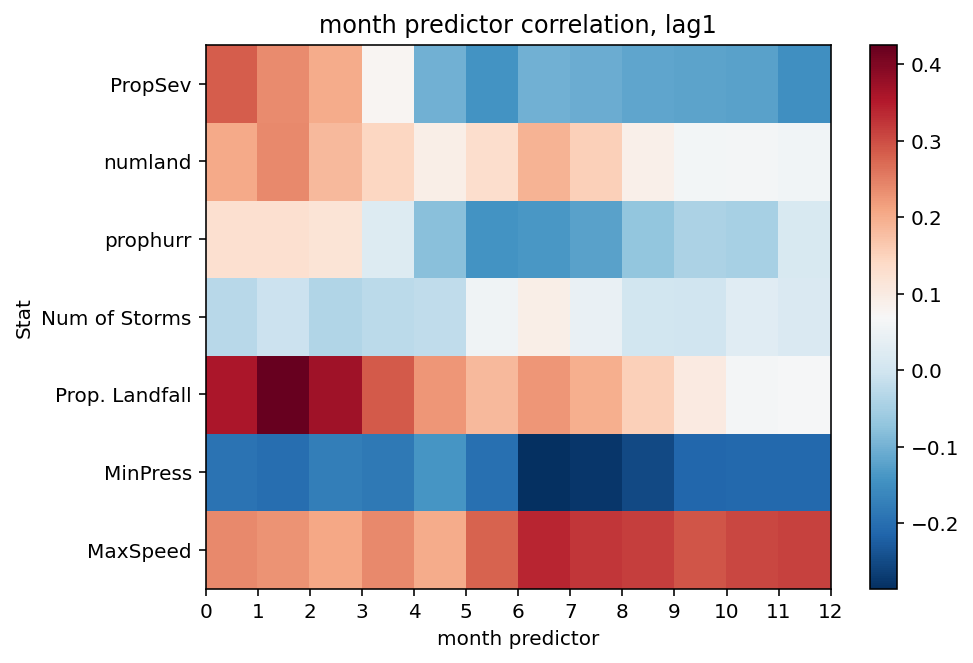

In [31]:
fig, ax = plt.subplots(figsize = (7, 5))  

g = ax.pcolormesh(np.arange(0, 12 + 1), np.arange(0, 8) + 0.5, cc1, vmax=cc1.max(), vmin=cc1.min(), cmap='RdBu_r')

ax.set_yticks(np.arange(1,8))
ax.set_yticklabels(['MaxSpeed','MinPress','Prop. Landfall', 'Num of Storms', 'prophurr','numland', 'PropSev'])
ax.set_xticks(np.arange(0,13))
plt.colorbar(g)
ax.set_ylabel('Stat')
ax.set_xlabel('month predictor')
ax.set_title('month predictor correlation, lag1');

In [37]:
from numpy.linalg import inv

#Lets regress February nino with landfall proportion NEXT YEAR

#Lag 2
preds = n34.n34.where(n34['T'].dt.month == 1, drop = True)[1:-2].values


N = len(preds)

y = resF['Prop'].values

Nx = len(preds)
X = np.empty((Nx,2))
X[:,1] = preds
X[:,0] = 1

beta = inv(X.T@X)@X.T@y
# print(beta.shape)
yhat = X@beta
# preds.shape

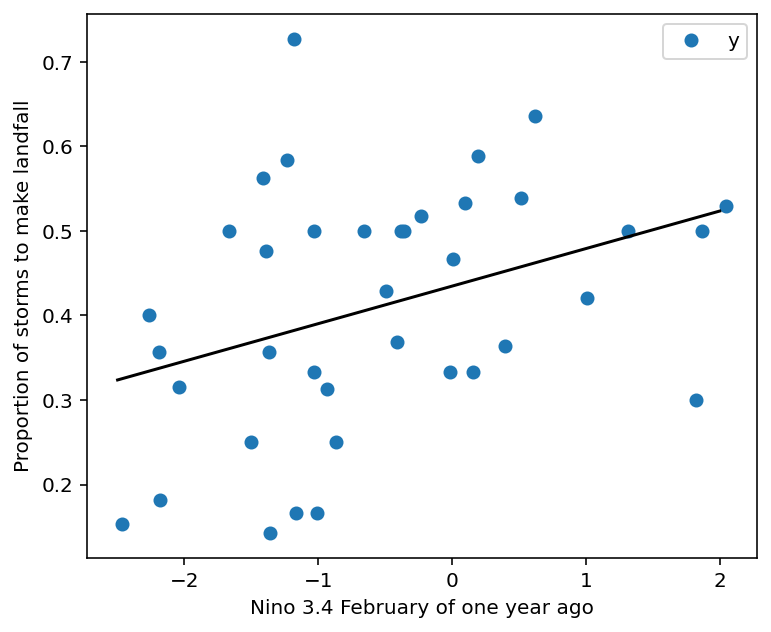

In [40]:
ig, ax = plt.subplots(figsize=(6, 5))
ax.plot(preds, y, 'o', label = 'y');
# ax.plot(preds, yhat, 'o', label = 'yhat');

ax.set_xlabel('Nino 3.4 February of one year ago')
ax.set_ylabel('Proportion of storms to make landfall');

x_line = np.linspace(-2.5, 2)
ax.plot(x_line, beta[1]*x_line + beta[0], color = 'k');

# for ii in range(0, N - 1):
#     ax.plot(preds[ii]*np.array([1,1]), np.array([yhat[ii], y[ii]]), color = 'k')
# ax.plot(preds[ii]*np.array([1,1]), np.array([yhat[ii], y[ii]]), color = 'k', label = 'residuals')
ax.legend();

In [41]:
#Lag2

cc3 = np.empty((7,12))
for imonth in range(0,12):
    if imonth != 10 and imonth != 11:
        cc3[0, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-3].values, resF['MaxSpeed'])
        cc3[1, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-3].values, resF['MinPress'])
        cc3[2, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-3].values, resF['Prop'])
        cc3[3, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-3].values, resF['Count'])
        cc3[4, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-3].values, resF['PropHurr'])
        cc3[5, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-3].values, resF['NumLand'])
        cc3[6, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-3].values, resF['PropSev'])
    else:
        cc3[0, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-2].values, resF['MaxSpeed'])
        cc3[1, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-2].values, resF['MinPress'])
        cc3[2, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-2].values, resF['Prop'])
        cc3[3, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-2].values, resF['Count'])
        cc3[4, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-2].values, resF['PropHurr'])
        cc3[5, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-2].values, resF['NumLand'])
        cc3[6, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[:-2].values, resF['PropSev'])

In [42]:
cc3[6,:]

array([-0.11757806, -0.11945358, -0.07760965,  0.02559999,  0.2028119 ,
        0.36450484,  0.40722335,  0.43864711,  0.44238768,  0.43404612,
        0.44179779,  0.37645488])

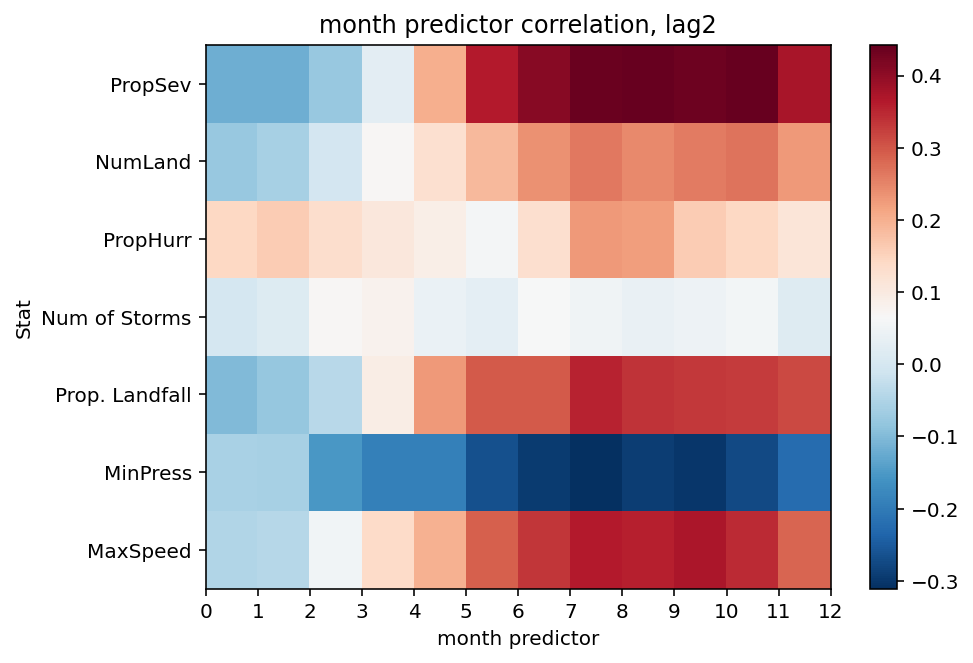

In [43]:
fig, ax = plt.subplots(figsize = (7, 5))  

g = ax.pcolormesh(np.arange(0, 12 + 1), np.arange(0, 8) + 0.5, cc3, vmax=cc3.max(), vmin = cc3.min(), cmap='RdBu_r')

ax.set_yticks(np.arange(1,8))
ax.set_yticklabels(['MaxSpeed','MinPress','Prop. Landfall', 'Num of Storms', 'PropHurr','NumLand','PropSev'])
ax.set_xticks(np.arange(0,13))
plt.colorbar(g)
ax.set_ylabel('Stat')
ax.set_xlabel('month predictor')
ax.set_title('month predictor correlation, lag2');

In [44]:
#Choose predictor
# preds = n34_Jul[2:-1]

In [45]:
# #Let's get some correlations!!!
# print("Correlation between April Nino and Landfall proportion: {}".format(cor(n34_Apr[2:-1], resF['Prop'].values)))
# print("Correlation between May Nino and Landfall proportion: {}".format(cor(n34_May[2:-1], resF['Prop'].values)))
# print("Correlation between June Nino and Landfall proportion: {}".format(cor(n34_Jun[2:-1], resF['Prop'].values)))
# print("Correlation between July Nino and Landfall proportion: {}".format(cor(n34_Jul[2:-1], resF['Prop'].values)))
# print()
# print("Correlation between April Nino and Total Storms: {}".format(cor(n34_Apr[2:-1], resF['Count'].values)))
# print("Correlation between May Nino and Total Storms: {}".format(cor(n34_May[2:-1], resF['Count'].values)))
# print("Correlation between June Nino and Total Storms: {}".format(cor(n34_Jun[2:-1], resF['Count'].values)))
# print("Correlation between July Nino and Total Storms: {}".format(cor(n34_Jul[2:-1], resF['Count'].values)))
# print()
# print("Correlation between April Nino and Max Wind Speed: {}".format(cor(n34_Apr[2:-1], resF['MaxSpeed'].values)))
# print("Correlation between May Nino and MWS: {}".format(cor(n34_May[2:-1], resF['MaxSpeed'].values)))
# print("Correlation between June Nino and MWS: {}".format(cor(n34_Jun[2:-1], resF['MaxSpeed'].values)))
# print("Correlation between July Nino and MWS: {}".format(cor(n34_Jul[2:-1], resF['MaxSpeed'].values)))
# print()
# print("Correlation between April Nino and Min Pressure: {}".format(cor(n34_Apr[2:-1], resF['MinPress'].values)))
# print("Correlation between May Nino and MP: {}".format(cor(n34_May[2:-1], resF['MinPress'].values)))
# print("Correlation between June Nino and MP: {}".format(cor(n34_Jun[2:-1], resF['MinPress'].values)))
# print("Correlation between July Nino and MP: {}".format(cor(n34_Jul[2:-1], resF['MinPress'].values)))

In [47]:
# from numpy.linalg import inv


#Lag 2
preds = n34_Sep[:-3]


N = len(preds)

y = resF['PropSev'].values

Nx = len(preds)
X = np.empty((Nx,2))
X[:,1] = preds
X[:,0] = 1

beta = inv(X.T@X)@X.T@y
# print(beta.shape)
yhat = X@beta

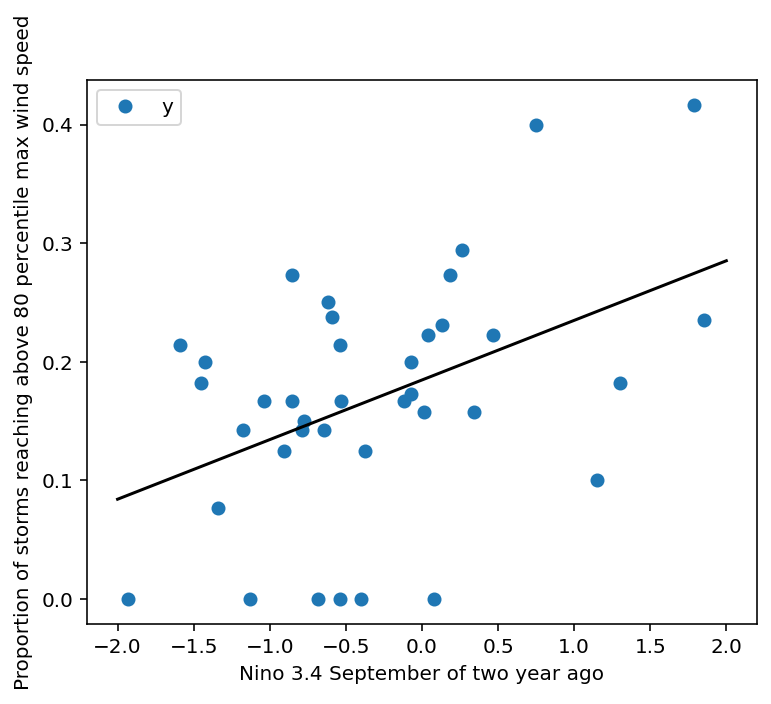

In [50]:
ig, ax = plt.subplots(figsize=(6, 5))
ax.plot(preds, y, 'o', label = 'y');
# ax.plot(preds, yhat, 'o', label = 'yhat');

ax.set_xlabel('Nino 3.4 September of two year ago')
ax.set_ylabel('Proportion of storms reaching above 80 percentile max wind speed');

x_line = np.linspace(-2, 2)
ax.plot(x_line, beta[1]*x_line + beta[0], color = 'k');

# for ii in range(0, N - 1):
#     ax.plot(preds[ii]*np.array([1,1]), np.array([yhat[ii], y[ii]]), color = 'k')
# ax.plot(preds[ii]*np.array([1,1]), np.array([yhat[ii], y[ii]]), color = 'k', label = 'residuals')
ax.legend();

BELOW HERE I TRY TO BOOTSTRAP.
IT DOES NOT SEEM TO BE GOING WELL.

---------------------------------------------------------------------------------------------------------------------------------------------------------########################################################################################################

In [52]:
n34r = n34.n34[24:-11]

In [53]:
nyears = np.floor_divide(len(n34r), 12)
nv = n34r.values
x2d = np.reshape(nv[0:(nyears*12)], (nyears, 12))

In [54]:
bootmax = 1000
wrk = np.zeros((bootmax,12))
resFb = np.zeros((bootmax,8))
for ii in range(0,bootmax):
        idx = np.random.choice(range(0,nyears),size=1)
        wrk[ii,:] = x2d[idx,:]
        resFb[ii,:] = resF.values[idx,:]


In [55]:
#Test some correlations

ccb = np.empty((7,12))
for imonth in range(0,12):
    ccb[0, imonth] = cor(wrk[:,imonth], resFb[:,3])
    ccb[1, imonth] = cor(wrk[:,imonth], resFb[:,4])
    ccb[2, imonth] = cor(wrk[:,imonth], resFb[:,6])
    ccb[3, imonth] = cor(wrk[:,imonth], resFb[:,7])
    ccb[4, imonth] = cor(wrk[:,imonth], resFb[:,2])
    ccb[5, imonth] = cor(wrk[:,imonth], resFb[:,5])
    ccb[6, imonth] = cor(wrk[:,imonth], resFb[:,1])
#     else:
#         cc[0, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:].values, resF['MaxSpeed'])
#         cc[1, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:].values, resF['MinPress'])
#         cc[2, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:].values, resF['Prop'])
#         cc[3, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:].values, resF['Count'])
#         cc[4, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:].values, resF['PropHurr'])
#         cc[5, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:].values, resF['NumLand'])
#         cc[6, imonth] = cor(n34.n34.where(n34['T'].dt.month == imonth+1, drop = True)[2:].values, resF['PropSev'])

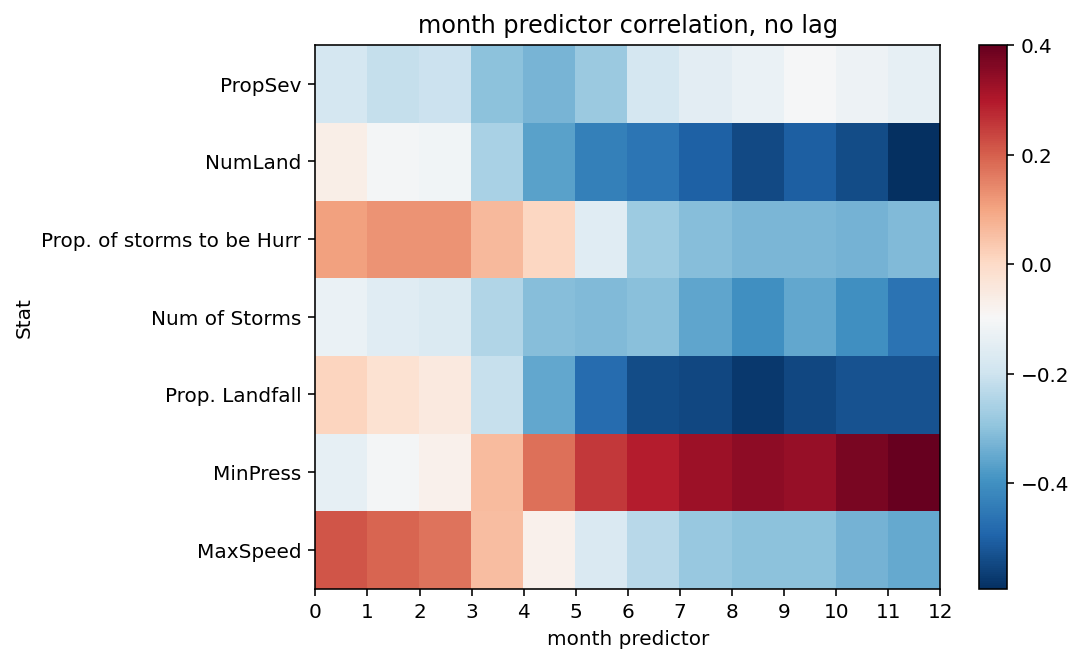

In [56]:
#Recreation of no lag plot, using bootstrapped data

fig, ax = plt.subplots(figsize = (7, 5))  

g = ax.pcolormesh(np.arange(0, 12 + 1), np.arange(0, 8) + 0.5, ccb, vmax=ccb.max(), vmin=ccb.min(), cmap='RdBu_r')

ax.set_yticks(np.arange(1,8))
ax.set_yticklabels(['MaxSpeed','MinPress','Prop. Landfall', 'Num of Storms', 'Prop. of storms to be Hurr', 'NumLand', 'PropSev'])
ax.set_xticks(np.arange(0,13))
plt.colorbar(g)
ax.set_ylabel('Stat')
ax.set_xlabel('month predictor')
ax.set_title('month predictor correlation, no lag');

In [57]:
resF.values[0]

array([1982, 0.25, 0.5, array(115.), array(950.), 1, 0.25, 4],
      dtype=object)

In [58]:
resFb[0]

array([1.99800000e+03, 1.42857143e-01, 7.14285714e-01, 1.55000000e+02,
       9.05000000e+02, 7.00000000e+00, 5.00000000e-01, 1.40000000e+01])

In [59]:
#Let's regress July with Prop Land

preds = wrk[:,6]


N = len(preds)

y = resFb[:,6]

Nx = len(preds)
X = np.empty((Nx,2))
X[:,1] = preds
X[:,0] = 1

beta = inv(X.T@X)@X.T@y
# print(beta.shape)
yhat = X@beta
# y

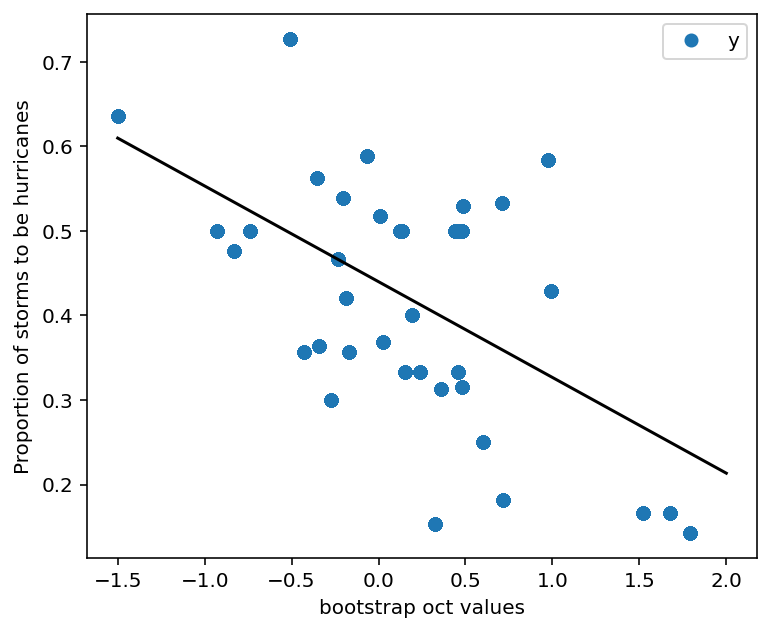

In [60]:
ig, ax = plt.subplots(figsize=(6, 5))
ax.plot(preds, y, 'o', label = 'y');
# ax.plot(preds, yhat, 'o', label = 'yhat');

ax.set_xlabel('bootstrap oct values')
ax.set_ylabel('Proportion of storms to be hurricanes');

x_line = np.linspace(-1.5, 2)
ax.plot(x_line, beta[1]*x_line + beta[0], color = 'k');

# for ii in range(0, N - 1):
#     ax.plot(preds[ii]*np.array([1,1]), np.array([yhat[ii], y[ii]]), color = 'k')
# ax.plot(preds[ii]*np.array([1,1]), np.array([yhat[ii], y[ii]]), color = 'k', label = 'residuals')
ax.legend();

In [61]:
#Recreation of starting year in November plot

#Test some correlations

ccbl = np.empty((7,12))
for imonth in range(0,12):
    if imonth != 10 and imonth != 11:
        ccbl[0, (imonth+2)%12] = cor(wrk[1:,imonth], resFb[1:,3])
        ccbl[1, (imonth+2)%12] = cor(wrk[1:,imonth], resFb[1:,4])
        ccbl[2, (imonth+2)%12] = cor(wrk[1:,imonth], resFb[1:,6])
        ccbl[3, (imonth+2)%12] = cor(wrk[1:,imonth], resFb[1:,7])
        ccbl[4, (imonth+2)%12] = cor(wrk[1:,imonth], resFb[1:,2])
        ccbl[5, (imonth+2)%12] = cor(wrk[1:,imonth], resFb[1:,5])
        ccbl[6, (imonth+2)%12] = cor(wrk[1:,imonth], resFb[1:,1])
    else:
        ccbl[0, (imonth+2)%12] = cor(wrk[:-1,imonth], resFb[1:,3])
        ccbl[1, (imonth+2)%12] = cor(wrk[:-1,imonth], resFb[1:,4])
        ccbl[2, (imonth+2)%12] = cor(wrk[:-1,imonth], resFb[1:,6])
        ccbl[3, (imonth+2)%12] = cor(wrk[:-1,imonth], resFb[1:,7])
        ccbl[4, (imonth+2)%12] = cor(wrk[:-1,imonth], resFb[1:,2])
        ccbl[5, (imonth+2)%12] = cor(wrk[:-1,imonth], resFb[1:,5])
        ccbl[6, (imonth+2)%12] = cor(wrk[:-1,imonth], resFb[1:,1])

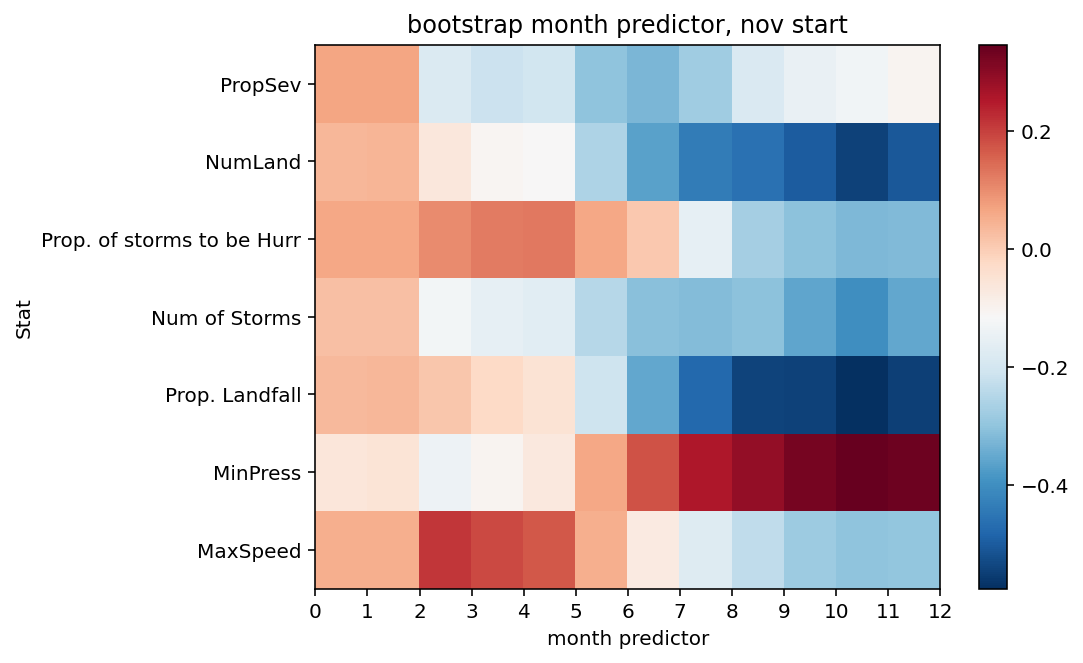

In [62]:
#Recreation of November start plot, using bootstrapped data

fig, ax = plt.subplots(figsize = (7, 5))  

g = ax.pcolormesh(np.arange(0, 12 + 1), np.arange(0, 8) + 0.5, ccbl, vmax=ccbl.max(), vmin=ccbl.min(), cmap='RdBu_r')

ax.set_yticks(np.arange(1,8))
ax.set_yticklabels(['MaxSpeed','MinPress','Prop. Landfall', 'Num of Storms', 'Prop. of storms to be Hurr', 'NumLand', 'PropSev'])
ax.set_xticks(np.arange(0,13))
plt.colorbar(g)
ax.set_ylabel('Stat')
ax.set_xlabel('month predictor')
ax.set_title('bootstrap month predictor, nov start');

In [63]:
ccb1 = np.empty((7,12))
for imonth in range(0,12):
    ccb1[0, imonth] = cor(wrk[:-1,imonth], resFb[1:,3])
    ccb1[1, imonth] = cor(wrk[:-1,imonth], resFb[1:,4])
    ccb1[2, imonth] = cor(wrk[:-1,imonth], resFb[1:,6])
    ccb1[3, imonth] = cor(wrk[:-1,imonth], resFb[1:,7])
    ccb1[4, imonth] = cor(wrk[:-1,imonth], resFb[1:,2])
    ccb1[5, imonth] = cor(wrk[:-1,imonth], resFb[1:,5])
    ccb1[6, imonth] = cor(wrk[:-1,imonth], resFb[1:,1])

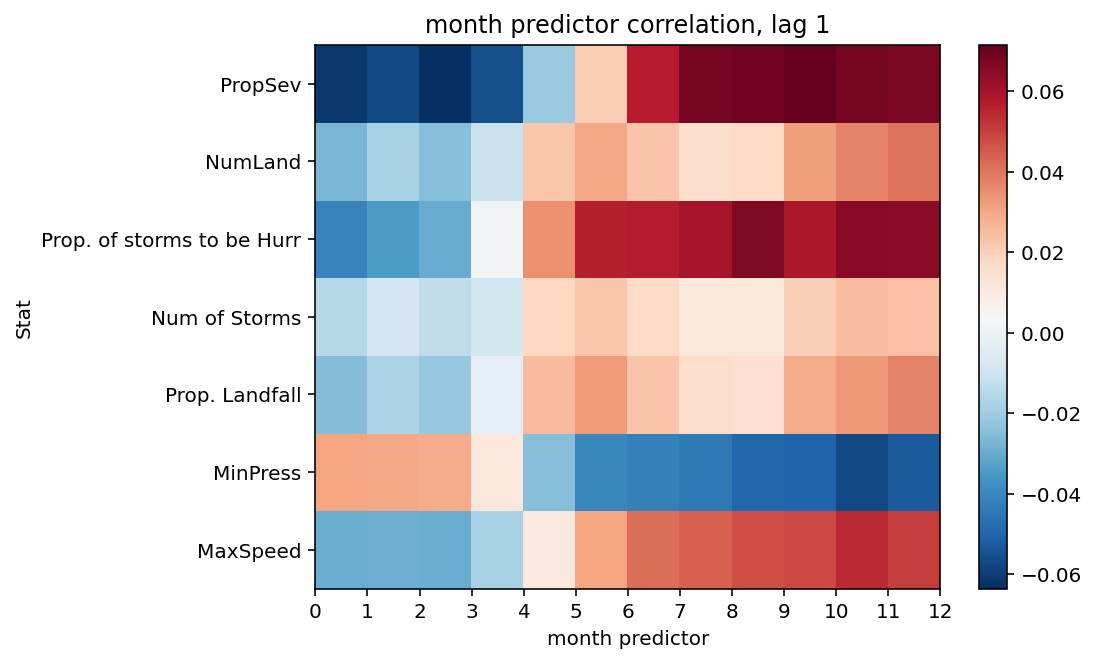

In [64]:
#Recreation of Lag 1, using bootstrapped data

fig, ax = plt.subplots(figsize = (7, 5))  

g = ax.pcolormesh(np.arange(0, 12 + 1), np.arange(0, 8) + 0.5, ccb1, vmax=ccb1.max(), vmin=ccb1.min(), cmap='RdBu_r')

ax.set_yticks(np.arange(1,8))
ax.set_yticklabels(['MaxSpeed','MinPress','Prop. Landfall', 'Num of Storms', 'Prop. of storms to be Hurr', 'NumLand', 'PropSev'])
ax.set_xticks(np.arange(0,13))
plt.colorbar(g)
ax.set_ylabel('Stat')
ax.set_xlabel('month predictor')
ax.set_title('month predictor correlation, lag 1');

In [65]:
#Regress december with prop hurr

preds = wrk[:,11]


N = len(preds)

y = resFb[:,1]

Nx = len(preds)
X = np.empty((Nx,2))
X[:,1] = preds
X[:,0] = 1

beta = inv(X.T@X)@X.T@y
# print(beta.shape)
yhat = X@beta
# y

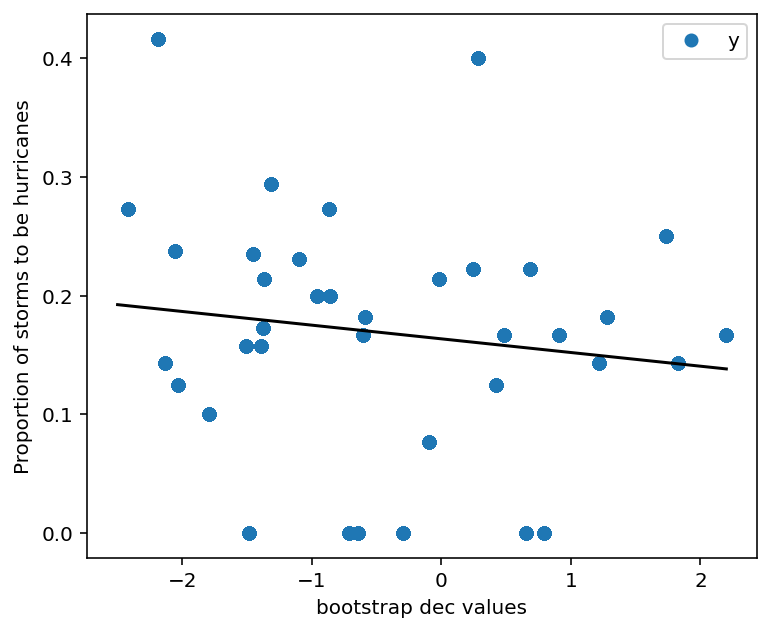

In [66]:
ig, ax = plt.subplots(figsize=(6, 5))
ax.plot(preds, y, 'o', label = 'y');
# ax.plot(preds, yhat, 'o', label = 'yhat');

ax.set_xlabel('bootstrap dec values')
ax.set_ylabel('Proportion of storms to be hurricanes');

x_line = np.linspace(-2.5, 2.2)
ax.plot(x_line, beta[1]*x_line + beta[0], color = 'k');

# for ii in range(0, N - 1):
#     ax.plot(preds[ii]*np.array([1,1]), np.array([yhat[ii], y[ii]]), color = 'k')
# ax.plot(preds[ii]*np.array([1,1]), np.array([yhat[ii], y[ii]]), color = 'k', label = 'residuals')
ax.legend();